### faster-rcnn checkpoint로부터 resnet weight 업로드 
* torch resnet50 모델과 업로드할 checkpoint의 key를 매칭함

In [2]:
import copy
import torch
from torchvision.models import resnet50, resnet101

model_path = '/root/data/frcnn_chkpt/frcnn_nf_1_20.pth' # base layer를 학습한 모델
model = resnet50(pretrained=True)

print("Loading pretrained weights from %s..." % (model_path))
print('-'*89)

state_dict = torch.load(model_path)
keys = list(model.state_dict().keys())
chk_keys = list(state_dict['model'].keys())
chk_values = list(state_dict['model'].values())

state_dict_cp = copy.deepcopy(state_dict)
for k,v in state_dict_cp['model'].items():
    elt = k.split('.')
    if k.startswith('RCNN_top'):
        new_k = 'layer%d.%s'%(int(elt[1])+4, '.'.join(elt[2:]))
        state_dict['model'][new_k] = state_dict['model'].pop(k)
        print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
        print('-'*89)
    elif k.startswith('RCNN_base'):
        if int(elt[1])>3:
            new_k = 'layer%d.%s'%(int(elt[1])-3, '.'.join(elt[2:]))
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
            print('-'*89)
        elif k=='RCNN_base.0.weight':
            new_k = 'conv1.weight'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
            print('-'*89)
        elif k=='RCNN_base.1.weight': 
            new_k = 'bn1.weight'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
            print('-'*89)
        elif k=='RCNN_base.1.bias': 
            new_k = 'bn1.bias'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
            print('-'*89)
        elif k=='RCNN_base.1.running_mean': 
            new_k = 'bn1.running_mean'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)) )
            print('-'*89)
        elif k=='RCNN_base.1.running_var': 
            new_k = 'bn1.running_var'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
            print('-'*89)
        elif k=='RCNN_base.1.num_batches_tracked': 
            new_k = 'bn1.num_batches_tracked'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
            print(f'{k}' + ' '*(47-len(k)) +'|' + f'{new_k}' + ' '*(42-len(new_k)))
            print('-'*89)
    else:
        print(f'{k}' + ' '*(47-len(k)) +'|' + ' '*(42))
        print('-'*89)

Loading pretrained weights from /root/data/frcnn_chkpt/frcnn_nf_1_20.pth...
-----------------------------------------------------------------------------------------
RCNN_rpn.RPN_Conv.weight                       |                                          
-----------------------------------------------------------------------------------------
RCNN_rpn.RPN_Conv.bias                         |                                          
-----------------------------------------------------------------------------------------
RCNN_rpn.RPN_cls_score.weight                  |                                          
-----------------------------------------------------------------------------------------
RCNN_rpn.RPN_cls_score.bias                    |                                          
-----------------------------------------------------------------------------------------
RCNN_rpn.RPN_bbox_pred.weight                  |                                          
-------------------

### resnet50 학습 weight 업로드 후 Grad CAM 적용

In [9]:
from pytorch_grad_cam import CAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50, resnet101
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
from PIL import Image
import torchvision
from torchvision import transforms
import torch


load_dict = copy.deepcopy(model.state_dict())
print('< wieghts loaded layers >')
for k in model.state_dict().keys():
    for _k, _v in state_dict['model'].items():
        if k==_k:
            load_dict[k] = _v
            print(_k, end = ' / ')


model.load_state_dict(load_dict)
target_layer = model.layer4[-1]
method = 'gradcam' # Can be gradcam/gradcam++/scorecam

img = cv2.imread('/root/data/R_tank_InHouseTanktest_side_RGB_800/0018.jpg')
img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_w, img_h  = img.shape[1], img.shape[0]
img_torch = Image.open('/root/data/R_tank_InHouseTanktest_side_RGB_800/0018.jpg').convert('RGB')
img_torch = transforms.Resize((224, 224))(img_torch)
img_torch =  torchvision.transforms.ToTensor()(img_torch).unsqueeze(0)
img_torch = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(img_torch)
input_tensor = img_torch


cam = CAM(model=model, target_layer=target_layer)
grayscale_cam = cam(input_tensor=input_tensor, target_category=1, method=method)
visualization = show_cam_on_image(img, grayscale_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
cam = heatmap + np.float32(img)
cam = cam / np.max(cam)

< wieghts loaded layers >
conv1.weight / bn1.weight / bn1.bias / bn1.running_mean / bn1.running_var / bn1.num_batches_tracked / layer1.0.conv1.weight / layer1.0.bn1.weight / layer1.0.bn1.bias / layer1.0.bn1.running_mean / layer1.0.bn1.running_var / layer1.0.bn1.num_batches_tracked / layer1.0.conv2.weight / layer1.0.bn2.weight / layer1.0.bn2.bias / layer1.0.bn2.running_mean / layer1.0.bn2.running_var / layer1.0.bn2.num_batches_tracked / layer1.0.conv3.weight / layer1.0.bn3.weight / layer1.0.bn3.bias / layer1.0.bn3.running_mean / layer1.0.bn3.running_var / layer1.0.bn3.num_batches_tracked / layer1.0.downsample.0.weight / layer1.0.downsample.1.weight / layer1.0.downsample.1.bias / layer1.0.downsample.1.running_mean / layer1.0.downsample.1.running_var / layer1.0.downsample.1.num_batches_tracked / layer1.1.conv1.weight / layer1.1.bn1.weight / layer1.1.bn1.bias / layer1.1.bn1.running_mean / layer1.1.bn1.running_var / layer1.1.bn1.num_batches_tracked / layer1.1.conv2.weight / layer1.1.bn2.wei

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


### 결과 이미지 확인

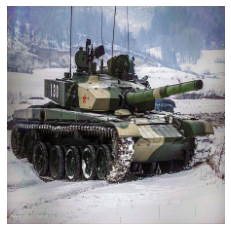

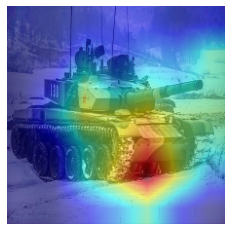

In [8]:
# 원본 이미지
plt.axis('off')
plt.imshow(img)
plt.show()

# Grad CAM 이미지
plt.axis('off')
plt.imshow(np.uint8(255 * cam))
plt.show()

### fine tuning

In [19]:

model_path = '/root/data/frcnn_chkpt/frcnn_1_20_frz.pth' # base layer를 학습한 모델
model = resnet50(pretrained=True)

print("Loading pretrained weights from %s..." % (model_path))
print('-'*89)

state_dict = torch.load(model_path)
keys = list(model.state_dict().keys())
chk_keys = list(state_dict['model'].keys())
chk_values = list(state_dict['model'].values())

state_dict_cp = copy.deepcopy(state_dict)
for k,v in state_dict_cp['model'].items():
    elt = k.split('.')
    if k.startswith('RCNN_top'):
        new_k = 'layer%d.%s'%(int(elt[1])+4, '.'.join(elt[2:]))
        state_dict['model'][new_k] = state_dict['model'].pop(k)
    elif k.startswith('RCNN_base'):
        if int(elt[1])>3:
            new_k = 'layer%d.%s'%(int(elt[1])-3, '.'.join(elt[2:]))
            state_dict['model'][new_k] = state_dict['model'].pop(k)
        elif k=='RCNN_base.0.weight':
            new_k = 'conv1.weight'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
        elif k=='RCNN_base.1.weight': 
            new_k = 'bn1.weight'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
        elif k=='RCNN_base.1.bias': 
            new_k = 'bn1.bias'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
        elif k=='RCNN_base.1.running_mean': 
            new_k = 'bn1.running_mean'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
        elif k=='RCNN_base.1.running_var': 
            new_k = 'bn1.running_var'
            state_dict['model'][new_k] = state_dict['model'].pop(k)
        elif k=='RCNN_base.1.num_batches_tracked': 
            new_k = 'bn1.num_batches_tracked'
            state_dict['model'][new_k] = state_dict['model'].pop(k)



Loading pretrained weights from /root/data/frcnn_chkpt/frcnn_1_20_frz.pth...
-----------------------------------------------------------------------------------------


In [20]:
load_dict = copy.deepcopy(model.state_dict())
print('< wieghts loaded layers >')
for k in model.state_dict().keys():
    for _k, _v in state_dict['model'].items():
        if k==_k:
            load_dict[k] = _v
            print(_k, end = ' / ')


model.load_state_dict(load_dict)
target_layer = model.layer4[-1]
method = 'gradcam' # Can be gradcam/gradcam++/scorecam

img = cv2.imread('/root/data/R_tank_InHouseTanktest_side_RGB_800/0018.jpg')
img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_w, img_h  = img.shape[1], img.shape[0]
img_torch = Image.open('/root/data/R_tank_InHouseTanktest_side_RGB_800/0018.jpg').convert('RGB')
img_torch = transforms.Resize((224, 224))(img_torch)
img_torch =  torchvision.transforms.ToTensor()(img_torch).unsqueeze(0)
img_torch = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(img_torch)
input_tensor = img_torch


cam = CAM(model=model, target_layer=target_layer)
grayscale_cam = cam(input_tensor=input_tensor, target_category=1, method=method)
visualization = show_cam_on_image(img, grayscale_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
cam = heatmap + np.float32(img)
cam = cam / np.max(cam)

< wieghts loaded layers >
conv1.weight / bn1.weight / bn1.bias / bn1.running_mean / bn1.running_var / bn1.num_batches_tracked / layer1.0.conv1.weight / layer1.0.bn1.weight / layer1.0.bn1.bias / layer1.0.bn1.running_mean / layer1.0.bn1.running_var / layer1.0.bn1.num_batches_tracked / layer1.0.conv2.weight / layer1.0.bn2.weight / layer1.0.bn2.bias / layer1.0.bn2.running_mean / layer1.0.bn2.running_var / layer1.0.bn2.num_batches_tracked / layer1.0.conv3.weight / layer1.0.bn3.weight / layer1.0.bn3.bias / layer1.0.bn3.running_mean / layer1.0.bn3.running_var / layer1.0.bn3.num_batches_tracked / layer1.0.downsample.0.weight / layer1.0.downsample.1.weight / layer1.0.downsample.1.bias / layer1.0.downsample.1.running_mean / layer1.0.downsample.1.running_var / layer1.0.downsample.1.num_batches_tracked / layer1.1.conv1.weight / layer1.1.bn1.weight / layer1.1.bn1.bias / layer1.1.bn1.running_mean / layer1.1.bn1.running_var / layer1.1.bn1.num_batches_tracked / layer1.1.conv2.weight / layer1.1.bn2.wei

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


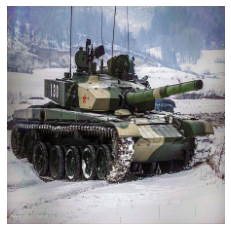

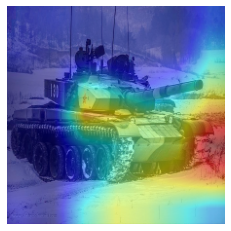

In [21]:
# 원본 이미지
plt.axis('off')
plt.imshow(img)
plt.show()

# Grad CAM 이미지
plt.axis('off')
plt.imshow(np.uint8(255 * cam))
plt.show()

### ImageNet pretrained

In [22]:
model = resnet50(pretrained=True)

model.load_state_dict(load_dict)
target_layer = model.layer4[-1]
method = 'gradcam' # Can be gradcam/gradcam++/scorecam

img = cv2.imread('/root/data/R_tank_InHouseTanktest_side_RGB_800/0018.jpg')
img = cv2.resize(img, dsize=(224,224), interpolation=cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


img_w, img_h  = img.shape[1], img.shape[0]
img_torch = Image.open('/root/data/R_tank_InHouseTanktest_side_RGB_800/0018.jpg').convert('RGB')
img_torch = transforms.Resize((224, 224))(img_torch)
img_torch =  torchvision.transforms.ToTensor()(img_torch).unsqueeze(0)
img_torch = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(img_torch)
input_tensor = img_torch


cam = CAM(model=model, target_layer=target_layer)
grayscale_cam = cam(input_tensor=input_tensor, target_category=1, method=method)
visualization = show_cam_on_image(img, grayscale_cam)

heatmap = cv2.applyColorMap(np.uint8(255 * grayscale_cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
cam = heatmap + np.float32(img)
cam = cam / np.max(cam)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


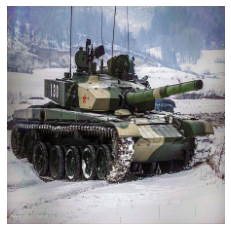

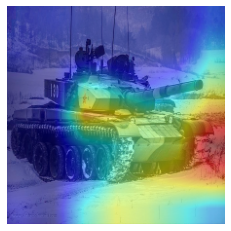

In [23]:
# 원본 이미지
plt.axis('off')
plt.imshow(img)
plt.show()

# Grad CAM 이미지
plt.axis('off')
plt.imshow(np.uint8(255 * cam))
plt.show()